In [14]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_dir = os.getenv("DATA_DIR")
print(data_dir)

/proj/sbaruah/data


In [20]:
attributes_file = os.path.join(data_dir, "mica-character-attribute-extraction/passage-attributes.csv")
print(attributes_file)

/proj/sbaruah/data/mica-character-attribute-extraction/passage-attributes.csv


In [19]:
attributes_df = pd.read_csv(attributes_file, index_col=None)
attributes_df.head()

,story-id,passage-id,passage,characters,attributes,completions
0,29870,500,as 2- chorus of a.pp :rcv i nc ad 11 bo follov...,ROCKY,"1. (Edvardt, action, steps up)\n2. (Rocky, emo...","{""id"":""chatcmpl-8N6poTf9Pqpfji4JAKCJBGzIkgj3K""..."
1,454082,93,The driver's side front end of Eve's car FILLS...,EVE;HEATHER;LEIGH,"Based on the provided passage, here are the ch...","{""id"":""chatcmpl-8N6pqrTJ0AL3rbawRgeCVAeH6BIGq""..."
2,1877830,100,HIGH OVER PENGUIN AND KENZIE - FROM THE WAREHO...,BATMAN;KENZIE;PENGUIN,"1. (Batman, location, high over Penguin and Ke...","{""id"":""chatcmpl-8N6puhXluPRC4qEyBrfTrPUuCZOLf""..."
3,6933454,72,Agnes sits down and watches as Maria sets the ...,AGNES;Agnes;MARIA;ROBERT,"1. (Agnes, action, sits down)\n2. (Agnes, beha...","{""id"":""chatcmpl-8N6pz3J2hoHE5Oqh11Zxzmcm4vDw0""..."
4,134119,24,"RIPLEY, a book in hand, unseen, walking up a h...",DICKIE;RIPLEY;SILVANA,"1. (RIPLEY, activity, walking)\n2. (RIPLEY, po...","{""id"":""chatcmpl-8N6q4zT18ih2idmWTsi119JkFUblJ""..."


In [21]:
for _, row in attributes_df.iterrows():
    passage = re.sub("\s+", " ", row["passage"].strip())
    print(passage)
    print("character attribute =>")
    print(row["attributes"])
    print()

as 2- chorus of a.pp :rcv i nc ad 11 bo follov!s fror.1 the other cells . Trie 11, as Edvte.rdt, steps up to take Rocky 1 s right arrn, Rocky- anrrily flint, ~s him off . Got this push hin
character attribute =>
1. (Edvardt, action, steps up)
2. (Rocky, emotion, angry)
3. (Rocky, action, flints him off)

The driver's side front end of Eve's car FILLS THE FRAME as Heather approaches, followed by Leigh. Heather aims her flashlight toward the Corolla's interior...
character attribute =>
Based on the provided passage, here are the character attributes extracted:

1. (Eve, possession, car)
2. (Heather, action, approaches)
3. (Heather, action, aims flashlight)
4. (Leigh, action, follows)

Please note that the attribute-type 'action' is used to describe an activity that the character is currently performing according to the text. The possession type attribute indicates that something belongs to the character, in this case, Eve's ownership of the car.

HIGH OVER PENGUIN AND KENZIE - FROM THE W

In [13]:
script_passages_df = pd.read_csv(os.path.join(data_dir, "mica-character-attribute-extraction/script-passages.csv"))
book_passages_df = pd.read_csv(os.path.join(data_dir, "mica-character-attribute-extraction/book-passages.csv"))

In [17]:
sampled_script_passages_df = script_passages_df.sample(10)
sampled_book_passages_df = book_passages_df.sample(10)
sampled_script_passages_df.rename(columns={"imdb-id": "story-id"}, inplace=True)
sampled_book_passages_df.rename(columns={"book": "story-id"}, inplace=True)
sampled_passages_df = pd.concat([sampled_script_passages_df, sampled_book_passages_df])
print(sampled_passages_df.shape)

for passage in sampled_passages_df["passage"]:
    print(re.sub("\s+", " ", passage.strip()))
    print()

(20, 4)
David opens his mouth obediently. Alex almost smiles. She feeds him for a while; they are both sizing each other up. Finally:

She steps out of the door. GRACE grabs her, tearing her blouse, and swings her back inside. They wrestle wildly, both whimpering and moaning. BILL watches from above as the fight imperceptibly transforms and mother and daughter are finally hugging each other and crying.

Bill finds them in the kitchen. Chuck goes into the other room to look for something. Abby lifts the cigarette out of Bill's mouth, takes a drag and does a French inhale. Bill kisses her.

Mandela eats breakfast -- porridge and fresh fruit -- and looks over the newspaper headlines, all screaming about today's World Cup final.

Lillian jerks involuntarily at the SOUND. Gittes pushes STOP. Then the PAST FORWARD. There is an electronic squeal of wire, then Gittes punches STOP and PLAY again. RAMSEY'S VOICE

(too thrilled to be prudent) Re was killed by Pazuzu, a very powerful demon. A crow

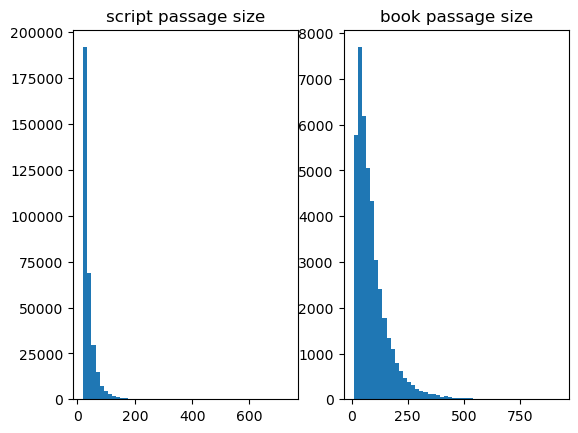

In [11]:
script_passage_sizes = script_passages_df["passage"].str.split().apply(len)
book_passage_sizes = book_passages_df["passage"].str.split().apply(len)
plt.subplot(1, 2, 1)
plt.hist(script_passage_sizes, bins=50)
plt.title("script passage size")
plt.subplot(1, 2, 2)
plt.hist(book_passage_sizes, bins=50)
plt.title("book passage size")
plt.show()

In [12]:
def statistics(arr):
    print(f"min = {min(arr)}, max = {max(arr)}, mean = {np.mean(arr):.1f}, std = {np.std(arr)}, "
          f"median = {np.median(arr)}")

print("script-passage size:")
statistics(script_passage_sizes)

print()

print("book-passage size:")
statistics(book_passage_sizes)

script-passage size:
min = 20, max = 735, mean = 39.2, std = 27.23052954918005, median = 31.0

book-passage size:
min = 10, max = 921, mean = 92.2, std = 77.48765394825477, median = 70.0
